<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/grad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModelOCT 

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import PIL
import plotly
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

## เตรียมชุดของข้อมูล

In [3]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/2022Project/for_code'  # data เราอยู่โฟล์เดอร์ไหน

In [5]:
batch_size = 32   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [6]:
# Train
train_dir = "/content/drive/My Drive/2022Project/for_code/train"
train_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 1216 images belonging to 4 classes.


In [7]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[304 304 304 304]


In [8]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [9]:
# Validation
val_dir ="/content/drive/My Drive/2022Project/for_code/validation"
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 152 images belonging to 4 classes.


In [10]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[38 38 38 38]


## Test

In [11]:
# Test
test_dir ="/content/drive/My Drive/2022Project/for_code/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 152 files belonging to 4 classes.


In [12]:
class_names = test_set.class_names
print(class_names)

['CSC', 'Normal', 'PCV', 'VKH']


## Training 

### สร้าง Model

In [13]:
num_classes = 4
epochs=10   # จำนวนครั้งที่เราจะ Train
# ขนาดภาพอินพุตเข้าสู่ Model
in_shape = (256,256,3)
in_shape

(256, 256, 3)

In [14]:
model = Sequential()   # สร้าง Model

# สร้างชั้น Convolution ชั้นแรก ค่าพารามิเตอร์ activation ใช้ ReLU
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = in_shape))
model.add(MaxPool2D((2,2)))    # สร้างชั้น Max Pooling ค่าพารามิเตอร์ 2,2 คือ Pool Size

# ชั้นที่ 2
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPool2D((2,2)))

# ชั้นที่ 3 
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

# FULLY CONNECTED LAYER
model.add(Flatten())

# Output layer
model.add(Dense(4, activation='softmax')) # 4 คลาส
model.summary()          # ดูสรุปโครงสร้าง Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

##### ดู kernel

In [15]:
for layer in model.layers:
  if 'conv' not in layer.name:
       continue
  kernels, biases = layer.get_weights()
  print(layer.name, 'shape:', kernels.shape)

conv2d shape: (3, 3, 3, 16)
conv2d_1 shape: (3, 3, 16, 32)
conv2d_2 shape: (3, 3, 32, 64)


In [16]:
k_min, k_max = kernels.min(), kernels.max()
kernels = (kernels - k_min)/ (k_max - k_min)
kernel_idx = 0
kernel_i = kernels[:, :, 0, kernel_idx]
print(kernel_i.round(2))

[[0.14 0.85 0.82]
 [0.11 0.05 0.58]
 [0.03 0.9  0.18]]


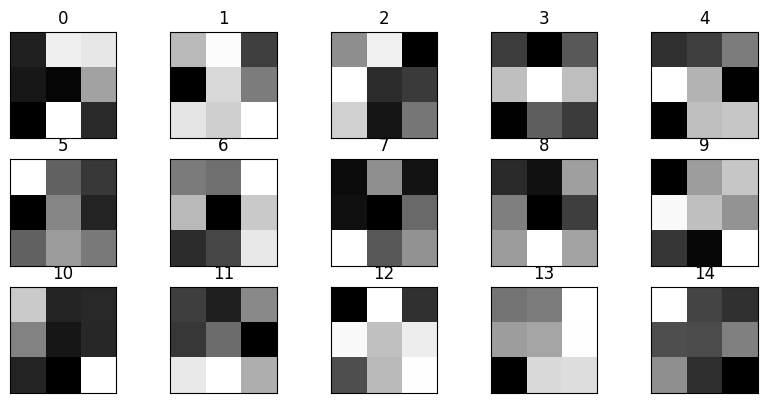

In [17]:
nplots = 15
fig = plt.figure(figsize = (10, 8))
for j in range(nplots):
  plt.subplot(5, 5, j+1)
  plt.imshow(kernels[:, :, 0, j], cmap = plt.cm.gray)
  plt.title(j)
  plt.xticks([]); plt.yticks([])
plt.show()

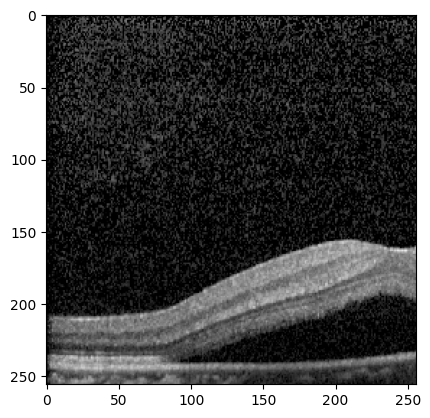

In [18]:
image = load_img('/content/drive/My Drive/2022Project/for_code/train/CSC/IA3870 19-12-16 RE_000_cropped.png', target_size=(256, 256))
plt.imshow(image)
plt.show()

In [19]:
img1 = img_to_array(image)
print('shape =', img1.shape)
print('max pixel value =', np.max(img1))

shape = (256, 256, 3)
max pixel value = 240.0


### Compile และ Train

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
start = time.time()

history = model.fit(train_set, steps_per_epoch=len(train_set), 
                    validation_data=val_set, 
                    epochs=10,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/10
38/38 [==============================] - 21s 396ms/step - loss: 1.2550 - accuracy: 0.4638 - val_loss: 1.5707 - val_accuracy: 0.2961
Epoch 2/10
38/38 [==============================] - 10s 271ms/step - loss: 0.7784 - accuracy: 0.6990 - val_loss: 2.2276 - val_accuracy: 0.2632
Epoch 3/10
38/38 [==============================] - 10s 272ms/step - loss: 0.4247 - accuracy: 0.8561 - val_loss: 2.5817 - val_accuracy: 0.2961
Epoch 4/10
38/38 [==============================] - 11s 284ms/step - loss: 0.2078 - accuracy: 0.9375 - val_loss: 3.1441 - val_accuracy: 0.2566
Epoch 5/10
38/38 [==============================] - 10s 274ms/step - loss: 0.1146 - accuracy: 0.9663 - val_loss: 4.1438 - val_accuracy: 0.2434
Epoch 6/10
38/38 [==============================] - 10s 274ms/step - loss: 0.0516 - accuracy: 0.9844 - val_loss: 4.1990 - val_accuracy: 0.3355
Epoch 7/10
38/38 [==============================] - 11s 293ms/step - loss: 0.0396 - accuracy: 0.9893 - val_loss: 4.8232 - val_accuracy: 0.2697

### Save Model

In [22]:
modelOCT = '/Model'
if not os.path.exists(path+modelOCT):
    os.makedirs(path+modelOCT)
os.makedirs('/content/drive/My Drive/2022Project/for_code/Model/', exist_ok=True)
model.save('/content/drive/MyDrive/2022Project/for_code/Model/modelOCT.h5')

with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='lastmodelOCT.h5'
model.save(filepath)
filepath_model = 'lastmodelOCT.json'
filepath_weights = 'weightsmodel.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weightsmodel.h5')
print("Saved model to disk")

Saved model to disk


### Load Model

In [23]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

## ประเมิน

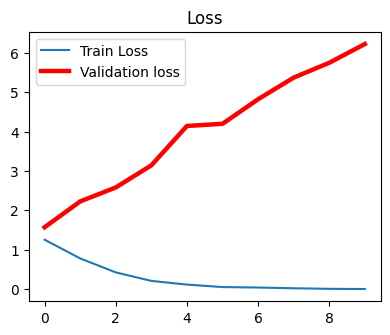

In [24]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

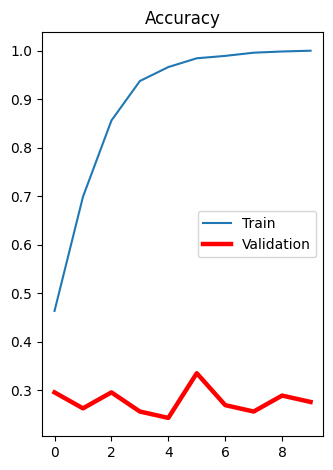

In [25]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.276


### Prediction

In [27]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image
from keras.models import load_model

In [28]:
train_set.class_indices

{'CSC': 0, 'Normal': 1, 'PCV': 2, 'VKH': 3}

1/1 [==============================] - 0s 180ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


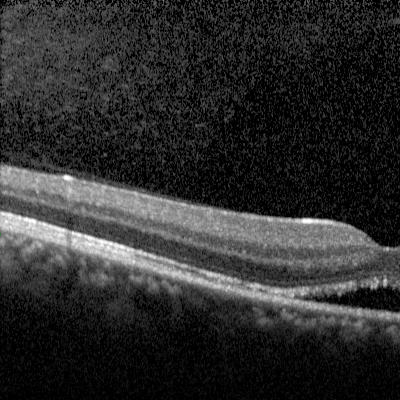

AI CSC มีความมั่นใจ 47.54%.


In [29]:
# CSC
test_path = ('/content/drive/My Drive/2022Project/for_code/test/CSC/GD7863 12-16-16 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 18ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536686, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


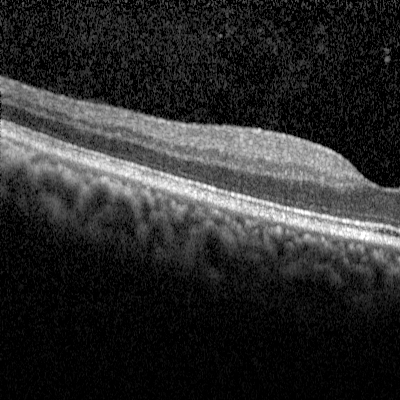

AI Normal มีความมั่นใจ 47.54%.


In [30]:
# Normal
test_path = ('/content/drive/My Drive/2022Project/for_code/test/Normal/CJ5901 24-01-19 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 18ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


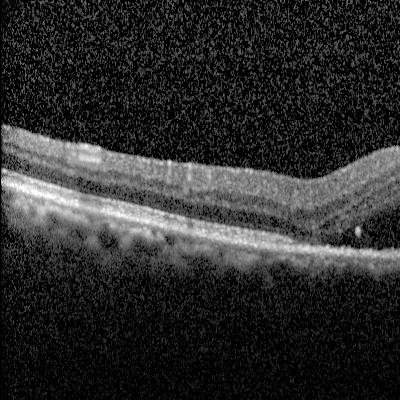

AI CSC มีความมั่นใจ 47.54%.


In [31]:
# PCV
test_path = ('/content/drive/My Drive/2022Project/for_code/test/PCV/AV0940 20-09-16 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 18ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


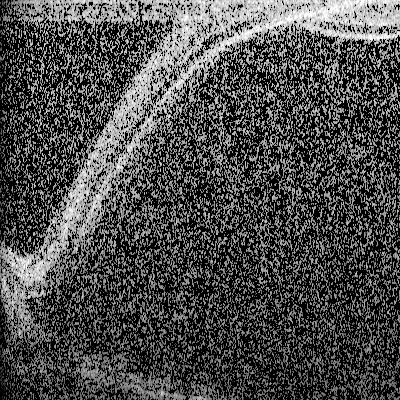

AI CSC มีความมั่นใจ 47.54%.


In [32]:
# VKH
test_path = ('/content/drive/My Drive/2022Project/for_code/test/VKH/KI2719 02-02-21 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [33]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "Normal"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 18ms/step


In [34]:
print(y_test)
print(len(y_test))

['PCV', 'CSC', 'PCV', 'CSC', 'CSC', 'CSC', 'Normal', 'Normal', 'VKH', 'VKH', 'Normal', 'PCV', 'VKH', 'Normal', 'VKH', 'VKH', 'CSC', 'VKH', 'CSC', 'CSC', 'CSC', 'VKH', 'PCV', 'CSC', 'Normal', 'CSC', 'Normal', 'PCV', 'PCV', 'CSC', 'Normal', 'VKH', 'PCV', 'Normal', 'PCV', 'VKH', 'CSC', 'PCV', 'CSC', 'PCV', 'Normal', 'Normal', 'Normal', 'PCV', 'VKH', 'PCV', 'Normal', 'CSC', 'CSC', 'Normal', 'PCV', 'VKH', 'VKH', 'PCV', 'Normal', 'Normal', 'VKH', 'Normal', 'CSC', 'PCV', 'VKH', 'PCV', 'Normal', 'CSC', 'VKH', 'CSC', 'VKH', 'PCV', 'VKH', 'VKH', 'PCV', 'PCV', 'PCV', 'CSC', 'VKH', 'Normal', 'VKH', 'Normal', 'VKH', 'VKH', 'Normal', 'Normal', 'Normal', 'PCV', 'CSC', 'PCV', 'Normal', 'VKH', 'VKH', 'CSC', 'PCV', 'PCV', 'Normal', 'Normal', 'VKH', 'PCV', 'CSC', 'VKH', 'PCV', 'VKH', 'CSC', 'VKH', 'PCV', 'Normal', 'CSC', 'CSC', 'CSC', 'PCV', 'Normal', 'Normal', 'VKH', 'PCV', 'VKH', 'CSC', 'CSC', 'Normal', 'Normal', 'VKH', 'VKH', 'CSC', 'Normal', 'PCV', 'CSC', 'VKH', 'PCV', 'CSC', 'CSC', 'PCV', 'CSC', 'CS

In [35]:
print(y_pred)
print(len(y_pred))

['CSC', 'CSC', 'PCV', 'CSC', 'CSC', 'VKH', 'VKH', 'Normal', 'CSC', 'VKH', 'Normal', 'CSC', 'VKH', 'CSC', 'VKH', 'CSC', 'CSC', 'PCV', 'CSC', 'CSC', 'CSC', 'VKH', 'CSC', 'CSC', 'CSC', 'VKH', 'CSC', 'PCV', 'CSC', 'CSC', 'Normal', 'VKH', 'CSC', 'VKH', 'PCV', 'PCV', 'CSC', 'PCV', 'CSC', 'CSC', 'VKH', 'VKH', 'Normal', 'PCV', 'VKH', 'PCV', 'Normal', 'CSC', 'VKH', 'VKH', 'Normal', 'VKH', 'VKH', 'CSC', 'Normal', 'CSC', 'PCV', 'VKH', 'PCV', 'Normal', 'VKH', 'PCV', 'Normal', 'VKH', 'PCV', 'CSC', 'VKH', 'PCV', 'VKH', 'VKH', 'CSC', 'PCV', 'PCV', 'CSC', 'CSC', 'Normal', 'VKH', 'Normal', 'VKH', 'VKH', 'VKH', 'Normal', 'VKH', 'CSC', 'CSC', 'CSC', 'Normal', 'PCV', 'PCV', 'CSC', 'CSC', 'CSC', 'VKH', 'Normal', 'VKH', 'CSC', 'CSC', 'VKH', 'CSC', 'CSC', 'CSC', 'CSC', 'CSC', 'Normal', 'CSC', 'VKH', 'CSC', 'PCV', 'Normal', 'VKH', 'PCV', 'PCV', 'VKH', 'CSC', 'CSC', 'VKH', 'CSC', 'PCV', 'PCV', 'CSC', 'Normal', 'PCV', 'CSC', 'VKH', 'PCV', 'CSC', 'CSC', 'CSC', 'VKH', 'CSC', 'CSC', 'VKH', 'CSC', 'VKH', 'VKH', 'No

## Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
confusion_matrix(y_test, y_pred)

array([[29,  0,  1,  8],
       [ 8, 16,  0, 14],
       [16,  4, 18,  0],
       [ 6,  0, 11, 21]])

In [38]:
cm = confusion_matrix(y_test, y_pred)

In [39]:
test_set.class_names

['CSC', 'Normal', 'PCV', 'VKH']

In [40]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'Normal', 'PCV', 'VKH'], 
                     columns = ['CSC', 'Normal', 'PCV', 'VKH'])

In [41]:
cm_df

,CSC,Normal,PCV,VKH
CSC,29,0,1,8
Normal,8,16,0,14
PCV,16,4,18,0
VKH,6,0,11,21


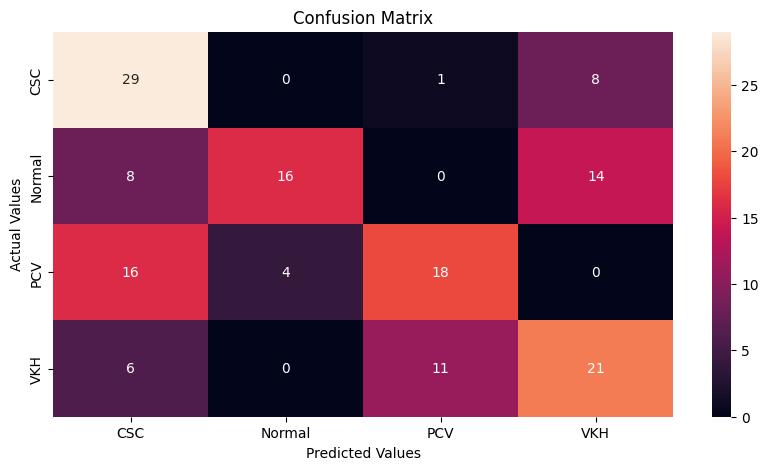

In [42]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

##  misclassify

In [43]:
# แสดง misclassify ว่ามีกี่ค่า
misclassify = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            misclassify += cm[i][j]
            
print('misclassification: ', misclassify)

misclassification:  68


In [44]:
# คำนวณค่า misclassification
misclassify = 1 - np.trace(cm) / np.sum(cm)

# Misclassification rate = จำนวนภาพที่ถูกจัดหมวดหมู่ผิด / จำนวนภาพทั้งหมดที่ใช้ในการทดสอบ

# แสดงผลลัพธ์ที่คิดเป็น %
print("Misclassification: {:.2f}%".format(misclassify*100))

Misclassification: 44.74%


## หาค่า Accuracy,Recall, Precision, F1-score

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [46]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.552632


In [47]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.552632


In [48]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.594974


In [49]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.549398


## Grad-CAM

In [50]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [51]:
# โหลดโมเดล
model = keras.models.load_model('lastmodelOCT.h5')

# โหลดน้ำหนัก
model.load_weights('weightsmodel.h5')

In [52]:
# Define target size for resizing image
target_size = (256, 256)

In [53]:
# Define class names
class_names = ['CSC', 'Normal', 'PCV', 'VKH']

In [54]:
# Load image from drive and resize
img_path = "/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png"
img = image.load_img(img_path, target_size=target_size)

In [55]:
# Convert image to array and preprocess
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)

# Expand dimensions to match model input shape
img_array = np.expand_dims(img_array, axis=0)

# Create gradient model with outputs from last convolutional layer and model predictions
last_conv_layer = model.get_layer('conv2d_2')
gradient_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])


In [56]:
# Calculate gradients with respect to last convolutional layer output
with tf.GradientTape() as tape:
    conv_output, predictions = gradient_model(img_array)
    loss = predictions[:, np.argmax(predictions[0])]
grads = tape.gradient(loss, conv_output)[0]


In [57]:
# Calculate global average pooling of gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Calculate weighted output of last convolutional layer
weighted_output = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)


In [58]:
# Apply ReLU activation function
weighted_output = tf.maximum(weighted_output, 0)

# Normalize weights
weighted_output /= tf.reduce_max(weighted_output)

In [59]:
# Resize weighted output to match original image size
weighted_output = tf.image.resize(weighted_output, target_size)

# Convert weighted output to numpy array
weighted_output = weighted_output.numpy()

แปลงภาพเป็นชนิด CV_8UC1 หรือ CV_8UC3 ก่อนจึงนำภาพไปใช้กับฟังก์ชัน cv2.applyColorMap()

In [60]:
import cv2

img = cv2.imread('/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png') # อ่านภาพจากไฟล์
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # แปลงภาพเป็น grayscale

# นำภาพ grayscale ไปใช้กับฟังก์ชัน applyColorMap
heatmap = cv2.applyColorMap(img_gray, cv2.COLORMAP_JET)

In [61]:
# 12. Overlay heatmap on original image
superimposed_img = cv2.addWeighted(img.astype('uint8'), 0.5, heatmap, 0.5, 0)

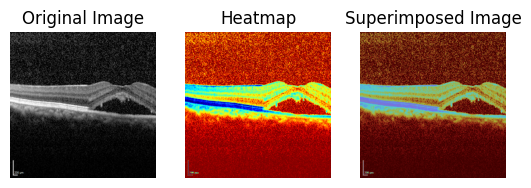

In [62]:
# 13. Plot original image, heatmap, and superimposed image
fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Original Image')
axs[1].imshow(heatmap)
axs[1].axis('off')
axs[1].set_title('Heatmap')
axs[2].imshow(superimposed_img)
axs[2].axis('off')
axs[2].set_title('Superimposed Image')
plt.show()

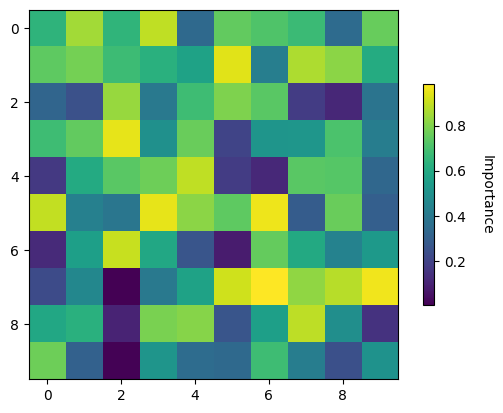

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a sample heatmap
heatmap = np.random.rand(10, 10)

# Determine the range of values
vmin, vmax = np.min(heatmap), np.max(heatmap)

# Plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(heatmap)

# Add the colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label('Importance', rotation=270, labelpad=20)

# Show the plot
plt.show()

# Grad-CAM

สร้างฟังก์ชัน GradCAM โดยรับโมเดล (model) และภาพต้นฉบับ (img) เข้ามา

In [64]:
def grad_cam(model, img):
    # ดึง output และชั้น conv2d_2 จากโมเดล
    conv_output, output = model.output[0], model.output[1]
    
    # คำนวณ gradient ของ output โดยที่เป้าหมายคือ output ที่มีค่าสูงสุด
    grads = K.gradients(output, conv_output)[0]

    # สร้างฟังก์ชัน keras.backend.function ในการคำนวณ gradient และ conv2d_2 จากภาพต้นฉบับ
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img])

    # หาค่าเฉลี่ยของ Gradient
    weights = tf.reduce_mean(grads_val, axis=(0, 1))

    # คูณ Gradient กับ Feature Map เพื่อสร้าง Heatmap
    cam = np.ones(output.shape[1:3], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Resize Heatmap เพื่อให้ขนาดเท่ากับภาพเดิมและทำการ Normalize Heatmap ให้อยู่ในช่วง 0-1
    cam = cv2.resize(cam.numpy(), (256, 256))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    # สร้างภาพ RGB ที่ Heatmap อยู่บนสีแดง
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # นำ Heatmap มาลงทับกับภาพต้นฉบับ
    superimposed_img = cv2.addWeighted(img[0], 0.5, heatmap, 0.5, 0)

    return superimposed_img

สร้างภาพต้นฉบับ (img) และแสดงภาพ Heatmap ที่ได้จาก GradCAM โดยใช้ฟังก์ชัน grad_cam() ที่สร้างไว้

In [65]:
# นำเข้าแพ็กเกจ OpenCV
import cv2

# สร้างภาพต้นฉบับ
img = cv2.imread("/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png")
img = cv2.resize(img, (256, 256))
img = np.expand_dims(img, axis=0)


In [66]:
# สร้างโมเดล
model = keras.models.load_model('lastmodelOCT.h5')

In [67]:
# ใช้ GradCAM เพื่อสร้าง Heatmap
import tensorflow as tf

x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x ** 2
dy_dx = tape.gradient(y, x)

print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


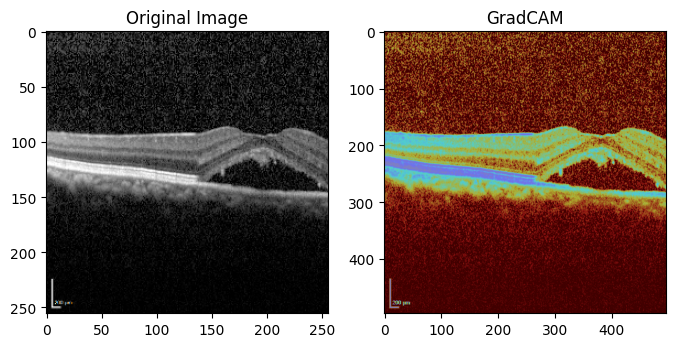

In [68]:
# สร้าง figure และ subplot
fig, axs = plt.subplots(1, 2, figsize=(8,5))

# แสดงผลภาพต้นฉบับและ Heatmap
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('GradCAM')

plt.show()

## Grad-CAM

จะต้องทำการอัปโหลดรูปภาพที่ต้องการทดสอบ และทำการ normalize ค่า pixel ในรูปภาพ

In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# อัปโหลดรูปภาพที่ต้องการทดสอบ
img_path =  "/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

# Normalize ค่า pixel ในรูปภาพ
img_array = np.array(img)
x = np.expand_dims(img_array, axis=0)
x = x / 255.0

ทำการคำนวณ Gradient และ Feature Map

In [70]:
import tensorflow as tf
from tensorflow import keras

# โหลดโมเดลที่เราสร้างเอง
model = keras.models.load_model('lastmodelOCT.h5')

# คำนวณ Gradient และ Feature Map
last_conv_layer = model.get_layer('conv2d_2')
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, np.argmax(predictions[0])]

grads = tape.gradient(loss, conv_outputs)[0]

# หาค่าเฉลี่ยของ Gradient
weights = tf.reduce_mean(grads, axis=(0, 1))

# คูณ Gradient กับ Feature Map เพื่อสร้าง Heatmap
cam = np.ones(grads.shape[0:2], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * grads[:, :, i]

cam = cv2.resize(cam.numpy(), (256, 256))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

<ipython-input-70-a229d0a69da7>:27: RuntimeWarning:

invalid value encountered in true_divide



สร้าง scale legend 

<function matplotlib.pyplot.show(close=None, block=None)>

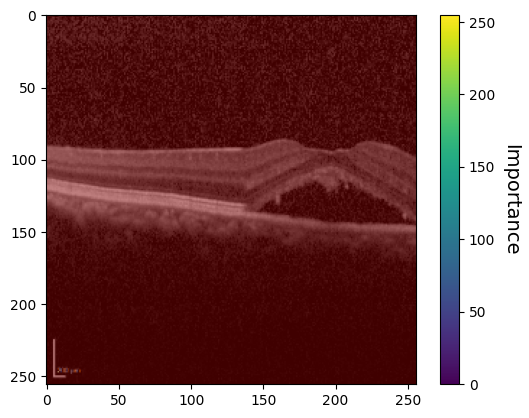

In [71]:
fig, ax = plt.subplots()
im = ax.imshow(img)

# สร้าง colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# กำหนดค่าของ colorbar
cbar.ax.set_ylabel('Importance', rotation=-90, va="bottom", fontsize=14)

# แสดง heatmap บนภาพ
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
ax.imshow(superimposed_img)

plt.show

## Grad-CAM

In [78]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [80]:
# โหลดโมเดล CNN
model = keras.models.load_model('lastmodelOCT.h5')

# โหลดและทำการเตรียมข้อมูล
image = tf.keras.preprocessing.image.load_img("/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png"
, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image = tf.keras.applications.resnet50.preprocess_input(image)

In [81]:
# สร้างฟังก์ชัน grad_cam
def grad_cam(input_model, image, cls, layer_name):
    # หา output layer ที่เกี่ยวข้องกับคลาสที่เราต้องการ
    output_layer = input_model.layers[-1].output
    # หา layer ก่อน output layer ที่เราต้องการดู Grad-CAM heatmap
    conv_layer = input_model.get_layer(layer_name).output
    # หา gradient ของ output layer ที่เกี่ยวข้องกับคลาสที่เราต้องการ
    grads = tf.GradientTape().gradient(output_layer[:, cls], conv_layer)[0]
    # หาค่า weighted sum ของ activation map และทำ global average pooling
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.ones(conv_layer.shape[1:3], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_layer[:, :, :, i]
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    return heatmap

tf.Tensor(6.0, shape=(), dtype=float32)


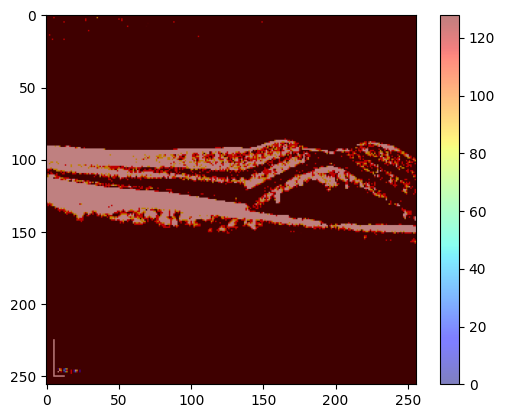

In [89]:
# ใช้ GradCAM เพื่อสร้าง Heatmap
import tensorflow as tf

x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x ** 2
dy_dx = tape.gradient(y, x)

print(dy_dx)

# แสดงผล Grad-CAM heatmap พร้อม scale legend
plt.imshow(image.squeeze())
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

## Grad-CAM

ฟังก์ชัน grad_cam ที่ใช้ GradientTape ในการคำนวณ Grad-CAM heatmap แล้ว สามารถทดสอบดูได้โดยการเรียกใช้ฟังก์ชัน grad_cam โดยระบุโมเดลที่เราสร้างเอง รูปภาพที่ต้องการสร้าง Grad-CAM heatmap และชื่อเลเยอร์ที่ต้องการดู Grad-CAM heatmap

In [92]:
def grad_cam(input_model, image, cls, layer_name):
    # หา output layer ที่เกี่ยวข้องกับคลาสที่เราต้องการ
    output_layer = input_model.layers[-1].output
    # หา layer ก่อน output layer ที่เราต้องการดู Grad-CAM heatmap
    conv_layer = input_model.get_layer(layer_name).output
    with tf.GradientTape() as tape:
        # สร้าง input tensor และ feed ให้กับโมเดล
        inputs = tf.cast(image, tf.float32)
        conv_output, predictions = input_model(inputs), output_layer
        # หา gradient ของ output layer ที่เกี่ยวข้องกับคลาสที่เราต้องการ
        grads = tape.gradient(predictions[:, cls], conv_output)
        # หาค่า weighted sum ของ activation map และทำ global average pooling
        weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
        cam = tf.reduce_sum(weights * conv_output, axis=-1)
    # ทำ scaling และ relu บน Grad-CAM heatmap
    cam = tf.nn.relu(cam)
    cam /= tf.reduce_max(cam)
    cam = tf.image.resize(cam, (224, 224))
    heatmap = cam.numpy()[0]
    return heatmap

In [94]:
# โหลดโมเดล CNN
model = keras.models.load_model('lastmodelOCT.h5')

# โหลดและทำการเตรียมข้อมูล
image = tf.keras.preprocessing.image.load_img("/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png"
, target_size=(256, 256))
# แปลงรูปภาพเป็น numpy array และทำ scaling ให้อยู่ในช่วง [0, 1]
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.
# ขยายขนาดของรูปภาพเพื่อสามารถส่งให้โมเดลได้
img_array = tf.expand_dims(img_array, 0)

tf.Tensor(6.0, shape=(), dtype=float32)


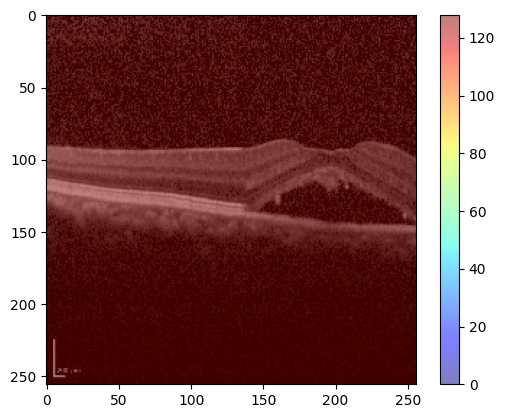

In [101]:
# ใช้ GradCAM เพื่อสร้าง Heatmap
import tensorflow as tf

x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x ** 2
dy_dx = tape.gradient(y, x)

print(dy_dx)

# แสดงผลรูปภาพและ Grad-CAM heatmap พร้อม scale legend
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

## Grad-CAM

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [107]:
# โหลดโมเดล CNN
model = keras.models.load_model('lastmodelOCT.h5')

# โหลดและทำการเตรียมข้อมูล
image = tf.keras.preprocessing.image.load_img("/content/drive/My Drive/01_68.jpg"
, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image = tf.keras.applications.resnet50.preprocess_input(image)

In [108]:
# สร้างฟังก์ชัน grad_cam
def grad_cam(input_model, image, cls, layer_name):
    # หา output layer ที่เกี่ยวข้องกับคลาสที่เราต้องการ
    output_layer = input_model.layers[-1].output
    # หา layer ก่อน output layer ที่เราต้องการดู Grad-CAM heatmap
    conv_layer = input_model.get_layer(layer_name).output
    # หา gradient ของ output layer ที่เกี่ยวข้องกับคลาสที่เราต้องการ
    grads = tf.GradientTape().gradient(output_layer[:, cls], conv_layer)[0]
    # หาค่า weighted sum ของ activation map และทำ global average pooling
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.ones(conv_layer.shape[1:3], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_layer[:, :, :, i]
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    return heatmap

tf.Tensor(6.0, shape=(), dtype=float32)


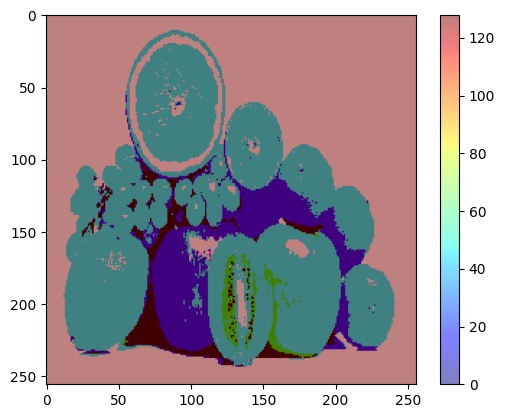

In [109]:
# ใช้ GradCAM เพื่อสร้าง Heatmap
import tensorflow as tf

x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x ** 2
dy_dx = tape.gradient(y, x)

print(dy_dx)

# แสดงผล Grad-CAM heatmap พร้อม scale legend
plt.imshow(image.squeeze())
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

# Grad-CAM

สร้างฟังก์ชัน GradCAM โดยรับโมเดล (model) และภาพต้นฉบับ (img) เข้ามา

In [117]:
def grad_cam(model, img):
    # ดึง output และชั้น conv2d_2 จากโมเดล
    conv_output, output = model.output[0], model.output[1]
    
    # คำนวณ gradient ของ output โดยที่เป้าหมายคือ output ที่มีค่าสูงสุด
    grads = K.gradients(output, conv_output)[0]

    # สร้างฟังก์ชัน keras.backend.function ในการคำนวณ gradient และ conv2d_2 จากภาพต้นฉบับ
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img])

    # หาค่าเฉลี่ยของ Gradient
    weights = tf.reduce_mean(grads_val, axis=(0, 1))

    # คูณ Gradient กับ Feature Map เพื่อสร้าง Heatmap
    cam = np.ones(output.shape[1:3], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Resize Heatmap เพื่อให้ขนาดเท่ากับภาพเดิมและทำการ Normalize Heatmap ให้อยู่ในช่วง 0-1
    cam = cv2.resize(cam.numpy(), (256, 256))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    # สร้างภาพ RGB ที่ Heatmap อยู่บนสีแดง
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # นำ Heatmap มาลงทับกับภาพต้นฉบับ
    superimposed_img = cv2.addWeighted(img[0], 0.5, heatmap, 0.5, 0)

    return superimposed_img

สร้างภาพต้นฉบับ (img) และแสดงภาพ Heatmap ที่ได้จาก GradCAM โดยใช้ฟังก์ชัน grad_cam() ที่สร้างไว้

In [118]:
# นำเข้าแพ็กเกจ OpenCV
import cv2

# สร้างภาพต้นฉบับ
img = cv2.imread("/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png")
img = cv2.resize(img, (256, 256))
img = np.expand_dims(img, axis=0)


In [119]:
# สร้างโมเดล
model = keras.models.load_model('lastmodelOCT.h5')

In [120]:
# ใช้ GradCAM เพื่อสร้าง Heatmap
import tensorflow as tf

x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x ** 2
dy_dx = tape.gradient(y, x)

print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


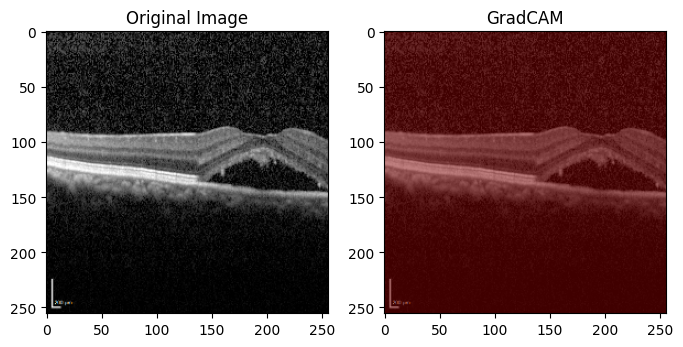

In [130]:
# สร้าง figure และ subplot
fig, axs = plt.subplots(1, 2, figsize=(8,5))

# แสดงผลภาพต้นฉบับและ Heatmap
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('GradCAM')

plt.show()